# CMSE 381 Final Project Template

**INSTRUCTIONS**: This is a template to help organize your project.  All projects should include the 5 major sections below (you do not need to use this template file).  If you use this file, complete your work below and remove content in parentheses. Also, remove this current cell.  

**Sarah***: Work on filling out project template as much as possible, Confusion Matrix per question 3 
**Thuy***: Split the files into X and Y, work on the SVM model per question 4
SELF DUE DATE: APRIL 7TH, meet in person, in wells hall 

Both: Work on K-Fold and subset selection per question 5 

#### CMSE 381 Final Project
### &#9989; Group members: Sarah Horan, Thuy Nguyen
### &#9989; Section_001
#### &#9989; 3/31/25

# ___PREDICTING FACE ORIETATION___

## Background and Motivation

How does the brain recognize not just who we’re looking at, but how they’re positioned in space? This question lies at the intersection of neuroscience and data science. In this project, we investigate how neurons in the anterior medial (AM) face patch of a macaque monkey respond when the animal views faces from different orientations. This brain region is known to be selective for facial features, and here we test whether its activity can reveal not just the presence of a face, but the **direction it's facing**.

The dataset we’re using comes from a study where a monkey passively viewed face images from 25 individuals, each shown in 8 different head orientations. For each image, researchers recorded binary neural spike data across a short time window (0–400 ms) following the image onset.

Our main goal is to explore whether we can **predict the orientation of a viewed face**—such as frontal, profile, or turned head—based on this neural activity alone. This is a classic example of a **neural decoding** task, where machine learning models are trained to extract meaning from complex biological signals.

Specifically, we aim to answer:
- **Can we classify face orientation based on patterns in neural spike data?**

By addressing these questions, we hope to gain insight into how the brain encodes spatial information about faces—and demonstrate how data science tools can uncover patterns in neural data that may not be obvious at first glance.


## Methodology
_(How did you go about answering your question(s)? You should wrote some code here to demonstrate what the data is like and how in principle your method works. You can leave the variations of the related to specific results to the results section.)_

In [1]:
import pandas as pd
import numpy as np
import glob
import zipfile
import io
import matplotlib.pyplot as plt
%matplotlib inline
import time
import seaborn as sns
from scipy.stats import uniform

# ML imports we've used previously
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# For today, we just need SVC
from sklearn.svm import SVC 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Data
* Describe the data you are using
* What variables are you using?: time spike data
    * What they mean?: the spike of AM when a part of the face showed up
    * Why did you choose them?: want to predict the orientation of the face. Each face reacts differently (need citation)

In [9]:
zip_path = "Sec001_Freiwald_Tsao_faceviews_AM_data_csv.zip"
X = []
y = []
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    csv_files = [f for f in zip_file.namelist() if f.endswith('.csv')]
    spike_data = []
    label_ref = []
    for csv in csv_files:
        with zip_file.open(csv) as file:
            df = pd.read_csv(file)
            spike_cols = [col for col in df.columns if col.startswith('time')]
            spike_data.append(df[spike_cols])
            label_ref.append(df[['labels.orientation']])
X = pd.concat(spike_data)
y = pd.concat(label_ref)

In [10]:
print(X.shape)
X.head()

(206216, 800)


,time.1_2,time.2_3,time.3_4,time.4_5,time.5_6,time.6_7,time.7_8,time.8_9,time.9_10,time.10_11,...,time.791_792,time.792_793,time.793_794,time.794_795,time.795_796,time.796_797,time.797_798,time.798_799,time.799_800,time.800_801
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since only the first 400ms is relevant for the labeled image (ADD CITATION). X can be formatted as below:

In [11]:
X = X.iloc[:, :400]
print(X.shape)
X.head()

(206216, 400)


,time.1_2,time.2_3,time.3_4,time.4_5,time.5_6,time.6_7,time.7_8,time.8_9,time.9_10,time.10_11,...,time.391_392,time.392_393,time.393_394,time.394_395,time.395_396,time.396_397,time.397_398,time.398_399,time.399_400,time.400_401
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
print(y.shape)
y.head()

(206216, 1)


,labels.orientation
0,front
1,front
2,front
3,front
4,front


In [13]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Models for classification _(if applicable)_
_(What models will you be using for classification? Why did you choose to use them? What questions would you answer with them? How would you evaluate if each model? What cross-validation method did you use?)_

In [7]:
# you may add some code here to show how the model works in principle

### Other methods used _(if applicable)_

Try GridSearchCV -- iterate through all combinations --> really slow for large dataset => use RandomizedSearchCV (ADD CITATION) where it samples a fixed number of combinations at random.

In [19]:
# merge X_train y_train into 1 dataset
train_data = X_train.copy()
train_data['label'] = y_train.values.ravel()

# sample 50000 random points from train_data 
train_sub = train_data.sample(n=50000, random_state=42)

# Split into X and y
X_sub = train_sub.drop(columns='label')
y_sub = train_sub['label'].values.ravel()

print("X_sub shape:", X_sub.shape)
print("y_sub shape:", y_sub.shape)

X_sub shape: (50000, 400)
y_sub shape: (50000,)


In [26]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)

p = X_train_sub.shape[1]

m_list = [int(np.sqrt(p)), int(p/2), int(p)]
print('m_list:', m_list)

n_tree_list = np.arange(10,201,10)
best_params = {}
best_error = float('inf')

Errors = []
for m in m_list:
    M_error = []
    for i in range(len(n_tree_list)):
        n_trees = n_tree_list[i]
        random_forest = RandomForestClassifier(max_features=m, n_estimators = n_trees, n_jobs=-1, max_depth=20).fit(X_train_sub, y_train_sub)
        error = 1 - accuracy_score(y_val_sub, random_forest.predict(X_val_sub))        
        M_error.append(error)
        if error < best_error:
            best_error = error
            best_params = {'max_features': m, 'n_estimators': n_trees, 'validation_error': best_error}
    Errors.append(np.array(M_error))
    

print("Best Parameters:")
print(f"max_features = {best_params['max_features']}")
print(f"n_estimators = {best_params['n_estimators']}")
print(f"validation error = {round(best_params['validation_error'], 6)}")

m_list: [20, 200, 400]
Best Parameters:
max_features = 400
n_estimators = 140
validation error = 0.863


# you may add some code here to show how the model works in principle

## Results

_(What did you find when you carried out your methods? Some of your code related to
presenting results/figures/data may be replicated from the methods section or may only be present in
this section. All of the plots that you plan on using for your presentation should be present in this
section)_

### classification results
_(What are you trying to do here?)_

In [ ]:
# how did you do it

_(How do you interpret what you see?)_

_(What are you doing next?)_

In [ ]:
# how did you do it (etc. etc.)

_(How do you interpret what you see?)_

_(What are you doing next?)_

In [ ]:
# how did you do it (etc. etc.)

### other results
_(What are you trying to do here?)_

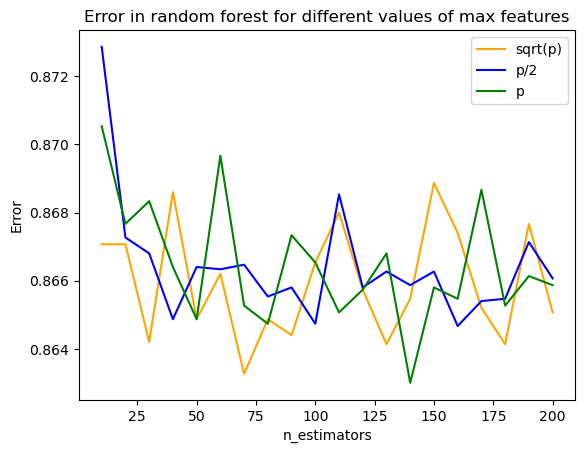

In [29]:
# If your code above works, below you'll get a plot of the different choices of m
colors = ['orange','blue','green']
labels = ['sqrt(p)', 'p/2', 'p']

for i in range(3):
    M_error = Errors[i]
    plt.plot(n_tree_list, M_error, label = labels[i], color = colors[i])

plt.legend()
plt.title('Error in random forest for different values of max features')
plt.xlabel("n_estimators")
plt.ylabel("Error")
plt.show()

_(How do you interpret what you see?)_

_(What are you doing next?)_

In [ ]:
# how did you do it (etc. etc.)

## Discussion and Conclusion

_(What did you learn from your results? What obstacles did you run into? What would you do differently next time? Clearly provide quantitative answers to your question(s)?  At least one of your questions should be answered with numbers.  That is, it is not sufficient to answer "yes" or "no", but rather to say something quantitative such as variable 1 increased roughly 10% for every 1 year increase in variable 2.)_

### discussion on the classification results

### discussion on the regression results

### discussion on the other results

### conclusion and future steps

## Author contribution

_(Please describe the contribution of each member of group)._

## References

_(List the source(s) for any data and/or literature cited in your project.  Ideally, this should be formatted using a formal citation format (MLA or APA or other, your choice!).   Multiple free online citation generators are available such as <a href="http://www.easybib.com/style">http://www.easybib.com/style</a>. **Important:** if you use **any** code that you find on the internet for your project you **must** cite it or you risk losing most/all of the points for you project.)_